# Load and Prepare Data

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [13]:
x_data = np.load('X_train.npy')
y_data = np.load('Y_train.npy')

In [14]:
def get_description(label):
    options = ['Normal',
               'Begnign Calcification',
               'Malignant Calcification',
               'Benign Mass',
               'Malignant Mass']
    
    return options[np.argmax(label)]

In [15]:
def get_binary_class(label):
    malignant_vector = [0,0,1,0,1]
    is_malignant = np.sum(label*malignant_vector)
    return np.array([1-is_malignant, is_malignant])

In [19]:
y_data_binary = np.apply_along_axis(get_binary_class, axis=1, arr=y_data)
y_data_binary.shape

(10713, 2)

In [11]:
x_data_3chan = np.empty(shape=(*x_data.shape,3))
for i in tqdm(range(x_data.shape[0])):
    x_data_3chan[i,...,0] = x_data[i]
    x_data_3chan[i,...,1] = x_data[i]    
    x_data_3chan[i,...,2] = x_data[i]

100%|██████████| 10713/10713 [00:14<00:00, 729.25it/s]


In [92]:
# predictions from the traditional network and samples of predictions from the bayesian network
y_preds = np.load('last_preds.npy')
prob_samples = np.load('samples_all.npy')

## Load Model

In [25]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [27]:
from keras.optimizers import SGD

In [28]:
inresv2_model_b = InceptionResNetV2(include_top=True, weights=None, classes=2)

In [29]:
inresv2_model_b.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['acc'])

In [30]:
inresv2_model_b.load_weights('checkpoint_bbbb.hdf5')

In [41]:
# input shape needs to be changed to work with keras-vis

new_model = InceptionResNetV2(include_top=True, weights=None, classes=2, input_shape=(256,256,3))

for idx,layer in tqdm(enumerate(inresv2_model_b.layers)):
    assert type(inresv2_model_b.layers[idx]) == type(new_model.layers[idx])
    new_model.layers[idx].set_weights(layer.get_weights())
    
new_model.compile(optimizer='sgd', loss='categorical_crossentropy')
print('New model initialized')

782it [42:26,  3.66s/it]

New model initialized


In [42]:
new_model.save('irv2_reordered.h5', include_optimizer=False)

## Visualization

In [73]:
from vis.visualization import visualize_saliency
from skimage.filters import gaussian

In [101]:
import random 

# This function takes the minimum and maximum probability for class 1 to filter on, and returns an array 
# of matching indices
def get_images_idx(min_prob, max_prob, orig_classified_malig=True):
    return np.where((y_preds[:,1] > min_prob) & (y_preds[:,1] < max_prob) & (y_data_binary[:,1] == orig_classified_malig))[0].tolist()

def visualize_saliency_maps(y_data_binary, y_preds, indices, num_show=4):
    fig = plt.figure(figsize=(15, num_show * 5))
    idxs = random.sample(indices, num_show)
    i = 1
    
    for idx in tqdm(idxs):   
    
        # plot original image
        ax = fig.add_subplot(num_show,3, i)
        plt.imshow(x_data_3chan[idx].astype('uint8'))
        plt.title('Malignant Ground Truth: ' + str(bool(y_data_binary[idx][1]))+'\n ID: '+str(idx))
        plt.grid(False)
        i += 1
        
        # plot saliency map
        ax = fig.add_subplot(num_show,3,i)
        grads = visualize_saliency(new_model, -4, filter_indices=None, seed_input=x_data_all[idx][None],
                           backprop_modifier='guided',
                           grad_modifier='absolute')
        filtered_grads = gaussian(grads, 3, multichannel=True)
        plt.imshow((filtered_grads*0.75)+(0.25*x_data_3chan[idx]/255))
        samples = prob_samples[:,idx,1]
        plt.title('Probability Malignant: ' + str(np.mean(samples)))
        plt.grid(False)
        i += 1
        
        # plot prediction distribution
        ax = fig.add_subplot(num_show,3,i)
        plt.hist(samples, bins=20, density=True)
        plt.title('Probability Distribution')
        i += 1

100%|██████████| 4/4 [04:31<00:00, 67.77s/it]


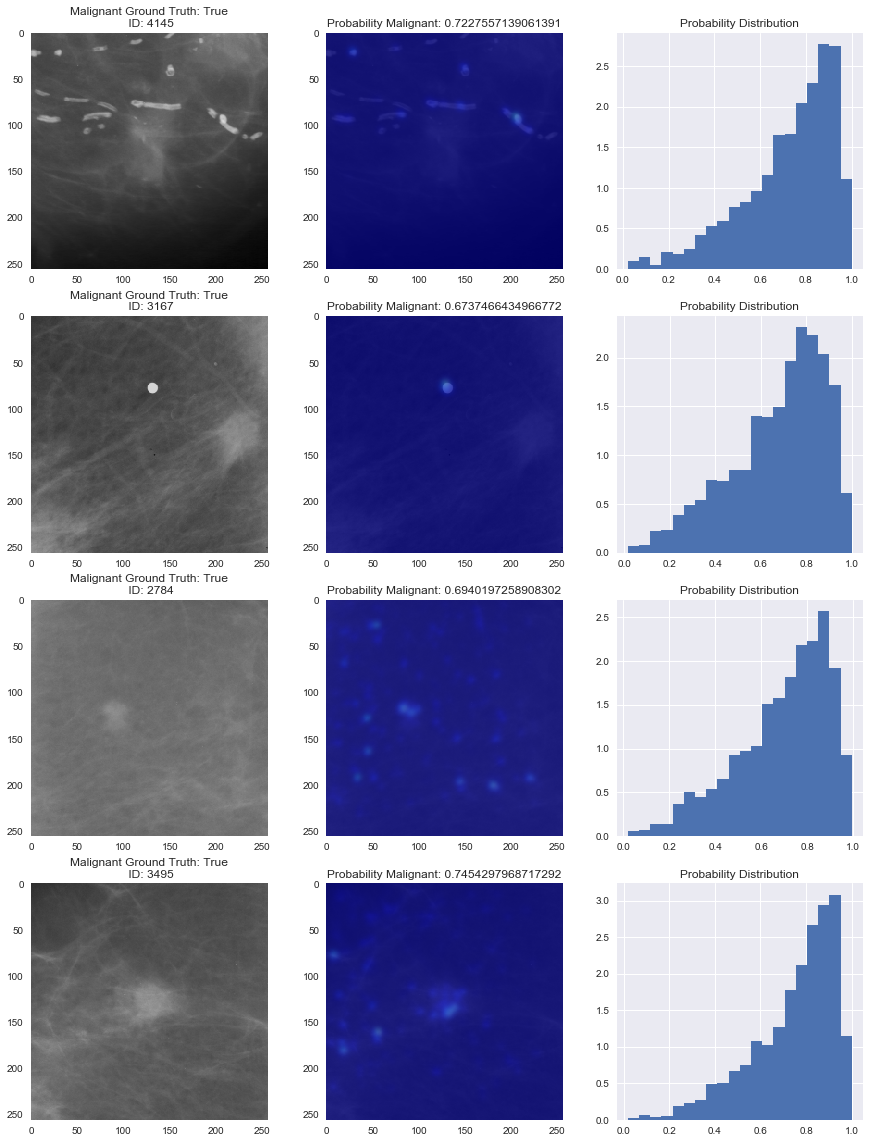

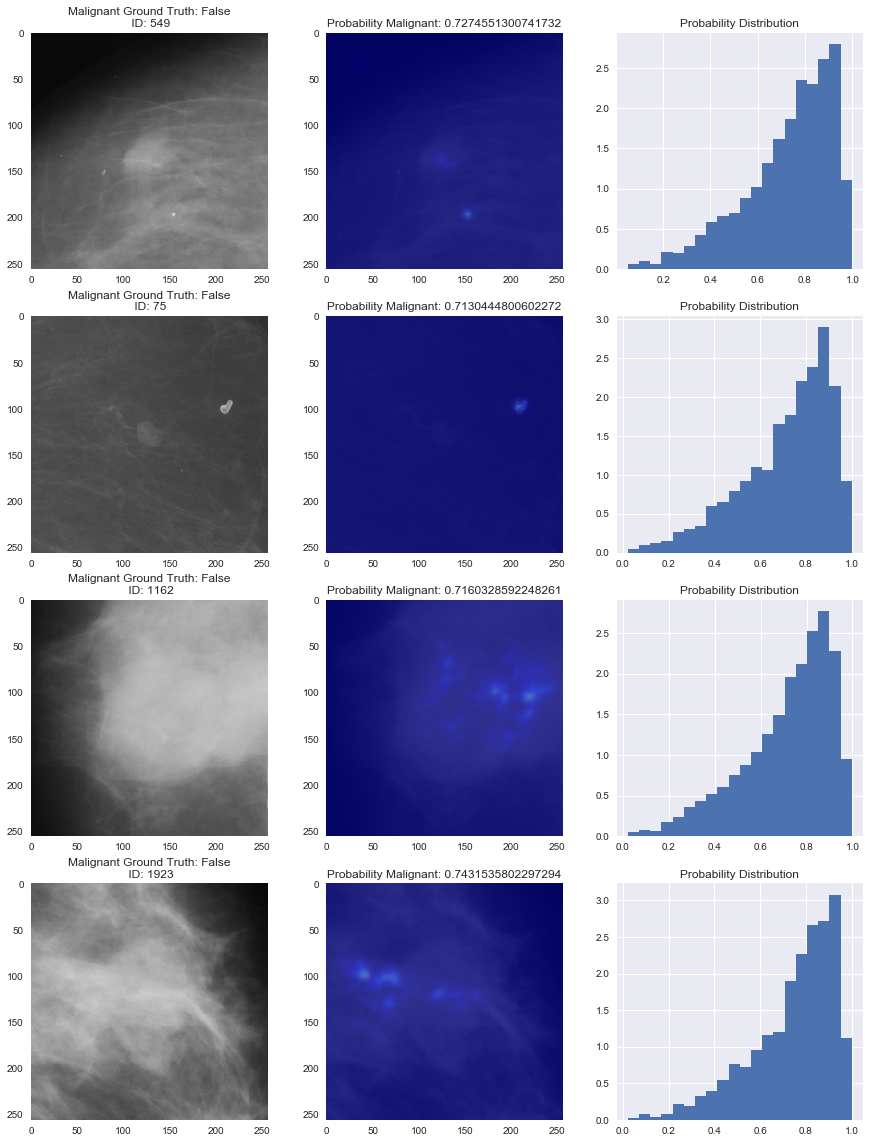

In [103]:
indices = get_images_idx(0.8, 1.0, orig_classified_malig=True)
visualize_saliency_maps(y_data_binary, y_preds, indices, num_show=4)
indices = get_images_idx(0.8, 1.0, orig_classified_malig=False)
visualize_saliency_maps(y_data_binary, y_preds, indices, num_show=4)

100%|██████████| 4/4 [04:50<00:00, 72.56s/it]


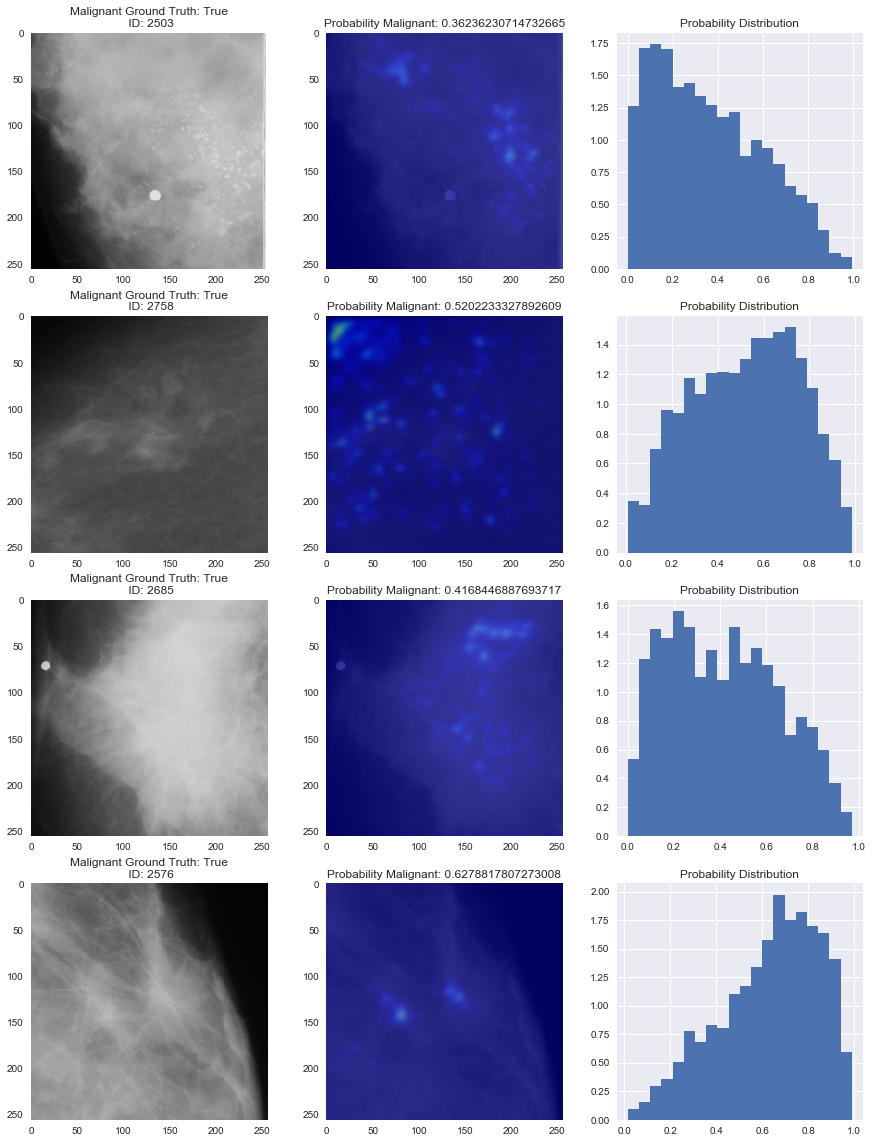

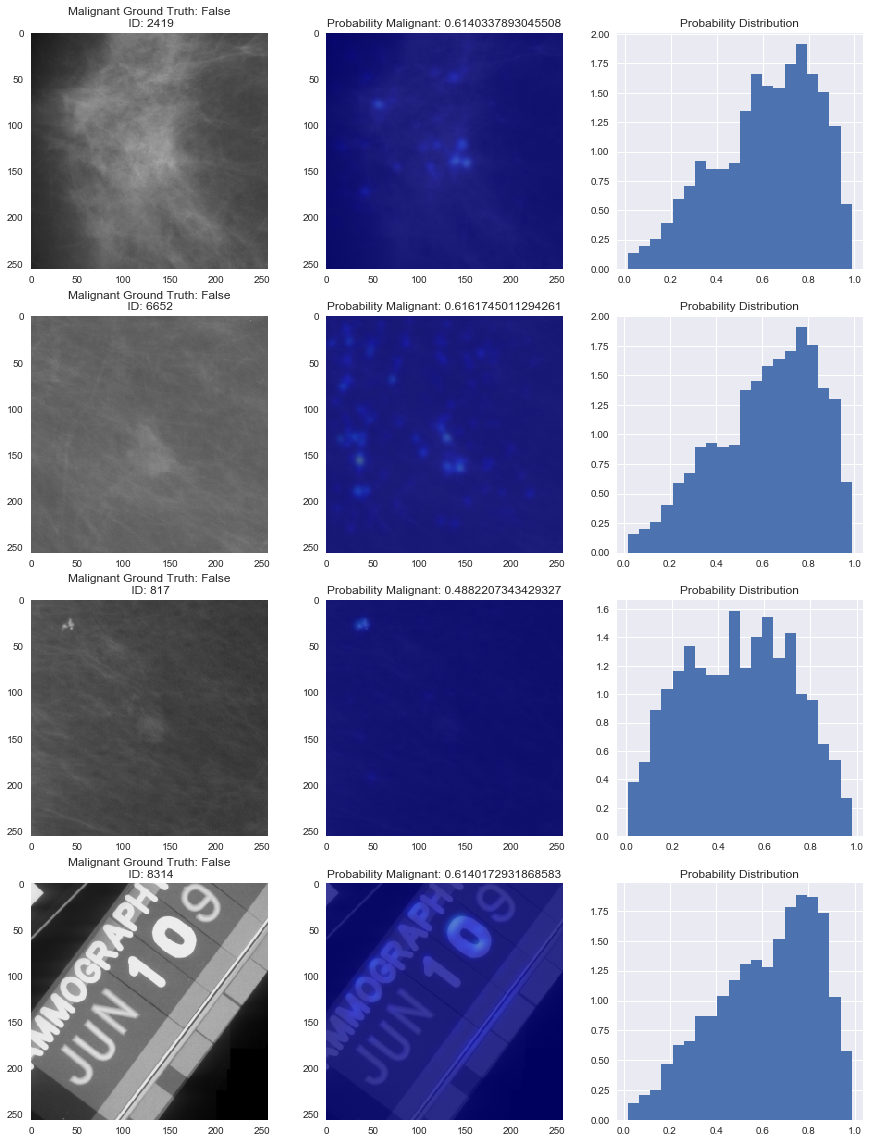

In [104]:
indices = get_images_idx(0.5, 0.7, orig_classified_malig=True)
visualize_saliency_maps(y_data_binary, y_preds, indices, num_show=4)
indices = get_images_idx(0.5, 0.7, orig_classified_malig=False)
visualize_saliency_maps(y_data_binary, y_preds, indices, num_show=4)

100%|██████████| 4/4 [05:36<00:00, 81.28s/it]


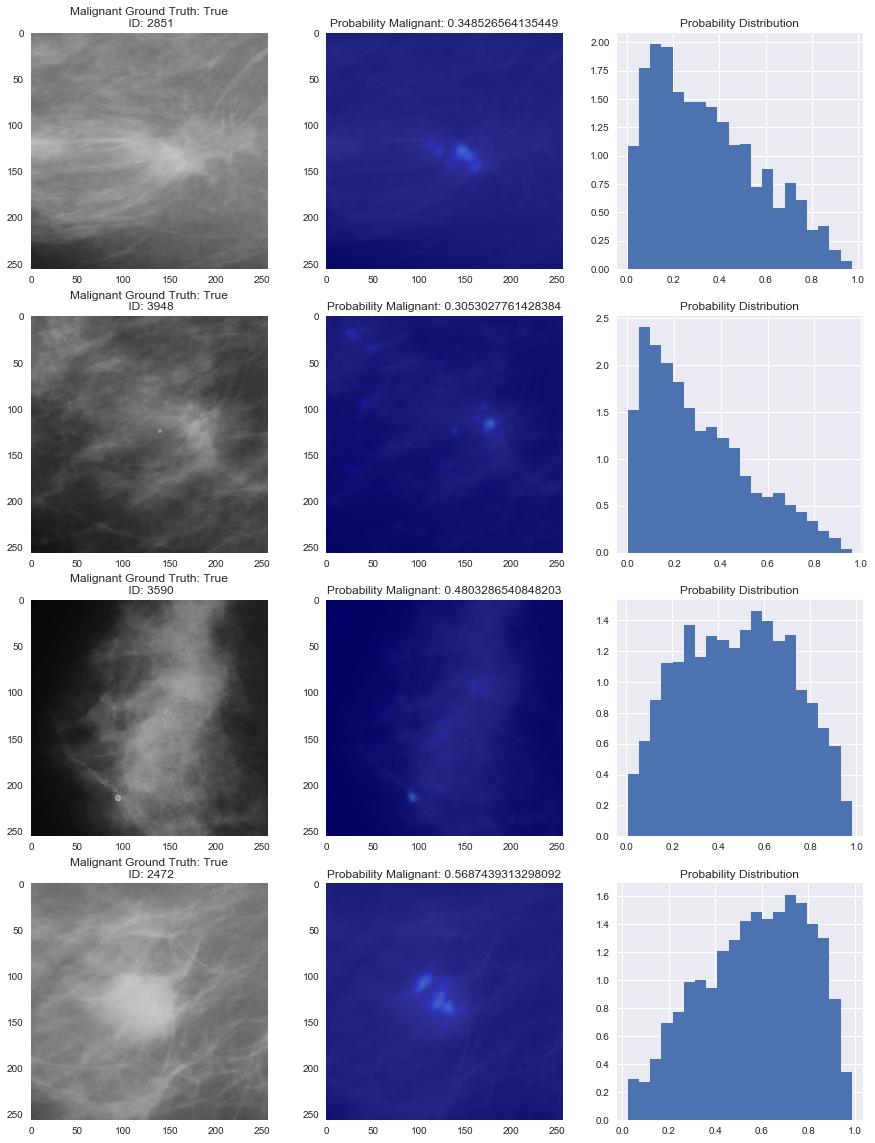

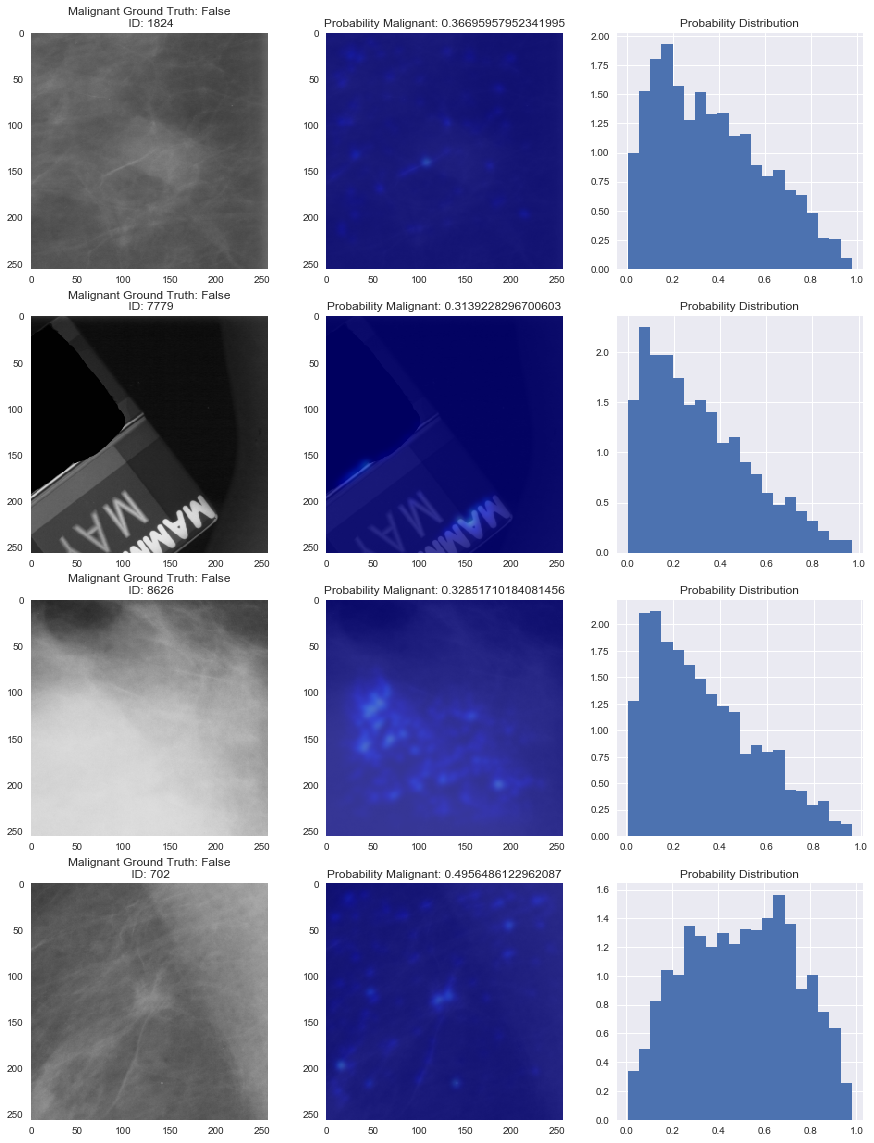

In [105]:
indices = get_images_idx(0.3, 0.5, orig_classified_malig=True)
visualize_saliency_maps(y_data_binary, y_preds, indices, num_show=4)
indices = get_images_idx(0.3, 0.5, orig_classified_malig=False)
visualize_saliency_maps(y_data_binary, y_preds, indices, num_show=4)

100%|██████████| 4/4 [05:27<00:00, 82.02s/it]


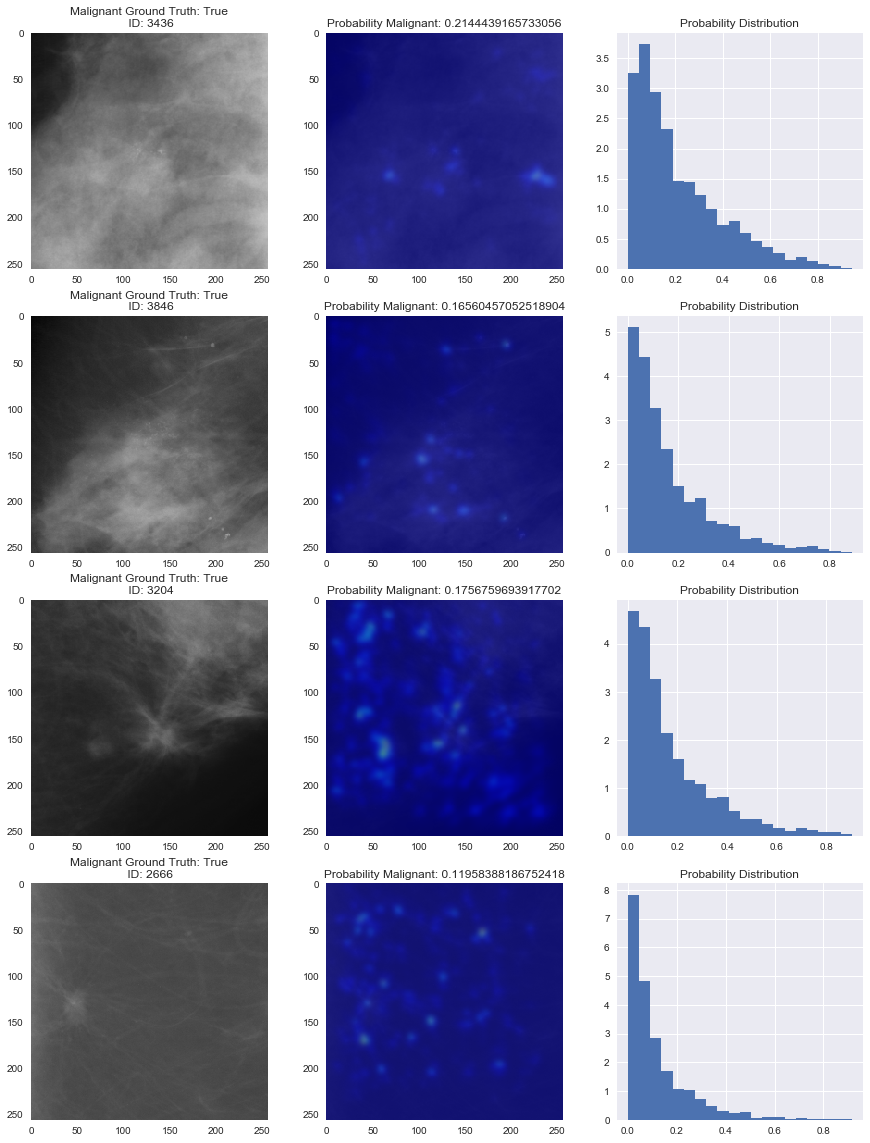

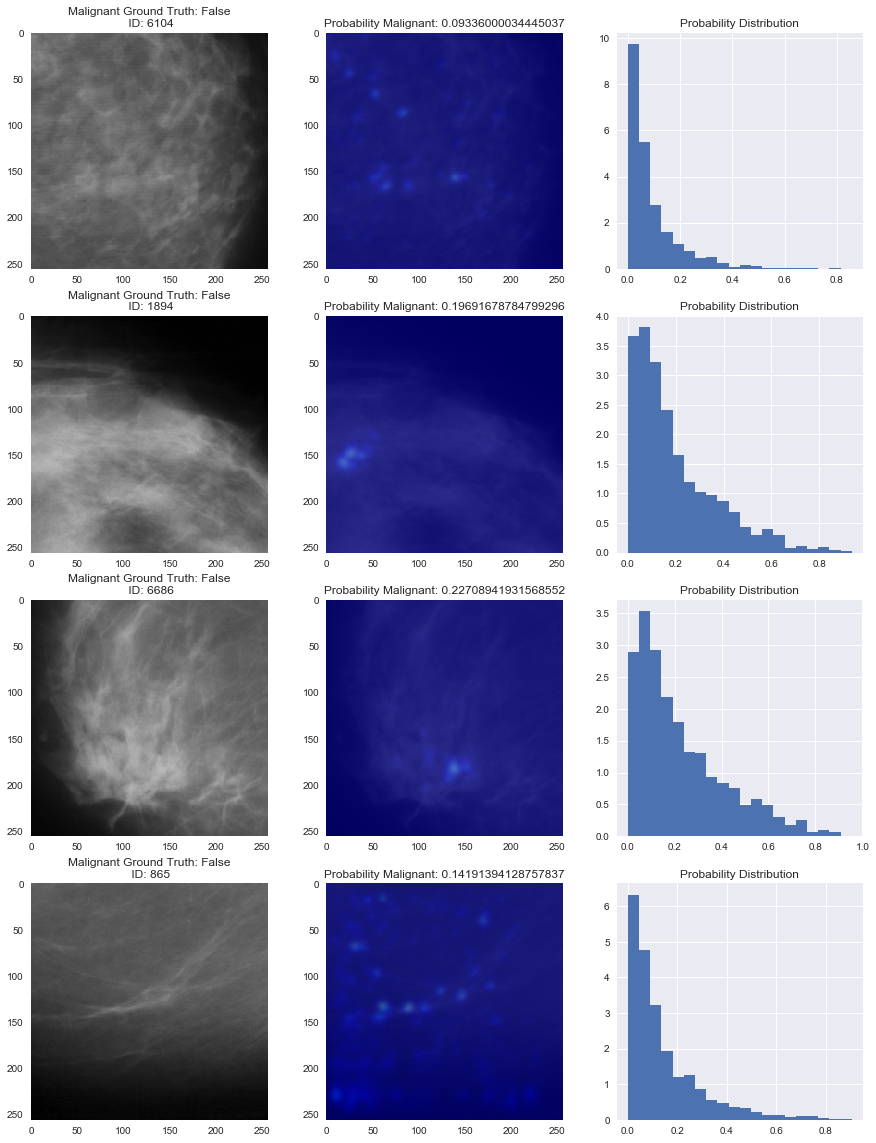

In [106]:
indices = get_images_idx(0.1, 0.3, orig_classified_malig=True)
visualize_saliency_maps(y_data_binary, y_preds, indices, num_show=4)
indices = get_images_idx(0.1, 0.3, orig_classified_malig=False)
visualize_saliency_maps(y_data_binary, y_preds, indices, num_show=4)